In [ ]:
%matplotlib inline

Utilities for writing Pycroscopy HDF5 files
============================================
Suhas Somnath

4/18/2018

Introduction
-------------
Pycroscopy uses a data-centric approach to data analysis and processing meaning that results from all data analysis and processing are written to the same h5 file that contains the recorded measurements. The Hierarchical Data Format (HDF5) allows data, whether it is raw measured data or results of analysis, to be stored in multiple datasets within the same file in a tree-like manner. Certain rules and considerations have been made in pycroscopy to ensure consistent and easy access to any data. 

The h5py python package provides great functions to create, read, and manage data in HDF5 files. In pycroscopy.hdf_utils, we have added functions that facilitate scientifically relevant, or pycroscopy specific functionality such as easy creation of Pycroscopy Main datasets, creation of automatically indexed groups to hold results of an analysis, etc. Due to the wide breadth of the functions in hdf_utils, the guide for hdf_utils will be split in two parts - one that focuses on functions that facilitate reading and one that facilitate writing of data. The following guide provides examples of how, and more importantly when, to use functions in pycroscopy.hdf_utils for various scenarios starting from recording data from instruments to storing analysis data.

Recommended pre-requisite reading
---------------------------------
* pycroscopy data format - https://pycroscopy.github.io/pycroscopy/data_format.html.
* Crash course on HDF5 and h5py - 

Import all necessary packages
-----------------------------
Before we begin demonstrating the numerous functions in pycroscopy.hdf_utils, we need to import the necessary packages. Here are a list of packages besides pycroscopy that will be used in this example:
* h5py - to open and close the file
* numpy - for numerical operations on arrays in memory
* matplotlib - basic visualization of data

In [1]:
from __future__ import print_function, division, unicode_literals
import os
# Warning package in case something goes wrong
from warnings import warn
import h5py
import numpy as np
import matplotlib.pyplot as plt
# Finally import pycroscopy.
try:
    import pycroscopy as px
except ImportError:
    warn('pycroscopy not found.  Will install with pip.')
    import pip
    pip.main(['install', 'pycroscopy'])
    import pycroscopy as px

C:\Users\Suhas\PycharmProjects\pycroscopy\pycroscopy\__init__.py:25: UserWarning: You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. Be advised - this branch changes very significantly and frequently. It is therefore not meant for usage. Use the master or dev branches for regular purposes.
  warn('You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. '


Create a HDF5 file 
==============================
We will be using the h5py functionality to do basic operations on HDF5 files

In [2]:
h5_file = h5py.File('test.h5')

HDF_Utils works with (and uses) h5py
------------------------------------

Pycroscopy and hdf_utils do not preclude the creation of groups and datasets using the h5py package. However, the many functions in hdf_utils are present to make it easier to handle the reading and writing of multidimensional scientific data formatted according to the Pycroscopy standard 

We can always use the h5py functionality to create a HDF5 group as shown below:

In [3]:
h5_some_group = h5_file.create_group('Some_Group')
print(h5_some_group)

<HDF5 group "/Some_Group" (0 members)>


In the same way, we can also continue to create datasets using h5py:

In [4]:
h5_some_dataset = h5_some_group.create_dataset('Some_Dataset', np.arange(5))
print(h5_some_dataset)

<HDF5 dataset "Some_Dataset": shape (0, 1, 2, 3, 4), type "<f4">


Create Groups
=======================
create_indexed_group()
---------------------
In order to accomodate the iterative nature of data recording (multiple sequential and related measurements) and analysis (same analysis performed with different parameters) we add an index as a suffix to HDF5 Group names. 

Let us first create a HDF5 group to store some data recorded from an instrument. The below function will automatically create a group with an index as a suffix and write certain book-keeping attributes to the group. We will see how this and similar functions handle situations when similarly named groups already exist.

In [5]:
h5_meas_group = px.hdf_utils.create_indexed_group(h5_file, 'Measurement')
print(h5_meas_group)

<HDF5 group "/Measurement_000" (0 members)>


Since there were no other groups whose name started with 'Measurement', the function assigned the lowest index - 000 as a suffix to the requested group name. 

create_indexed_group() calls another handy function called assign_group_index() to get the suffix before creating a HDF5 group. Should we want to create another new indexed group called 'Measurement', assign_group_index() will notice that a group named 'Measurement_000' already exists and will assign the next index (001) to the new group - see below. Note that assign_group_index() does not create the group; it only assigns a non-conflicting string name for the group.

In [6]:
print(px.hdf_utils.assign_group_index(h5_file, 'Measurement'))

Measurement_001


Now lets look at datasets and groups in the created file:

In [7]:
print('Contents within the file so far:')
px.hdf_utils.print_tree(h5_file)

Contents within the file so far:
/
├ Measurement_000
  ---------------
├ Some_Group
  ----------
  ├ Some_Dataset


Clearly, we have the 'Measurement_000' Group at the same level as a group named 'Some_Group'. The group 'Some_Group' contains a dataset named 'Some_Dataset' under it. 

Both, 'Measurement_000' and 'Some_Group' have an underline below their name to indicate that they are groups unlike the 'Some_Dataset' Dataset

Writing attributes
======================
HDF5 datasets and datagroups can also store metadata such as experimental parameters. These metadata can be text,
numbers, small lists of numbers or text etc. These metadata can be very important for understanding the datasets
and guide the analysis routines.

While one could use the basic h5py functionality to write and access attributes, one would encounter a lot of problems when attempting to encode or decode attributes whose values were strings or lists of strings due to some issues in h5py. This problem has been demonstrated in our primer to HDF5. Instead of using the basic functionality of h5py, we recommend always using the functions in pycroscopy that reliably and consistently work for any kind of attribute for any version of python: 

Here's a look at the self-explanatory, default attribtues that will be written to the indexed group for traceability and posterity. Note that we are using pycrocsopy's get_attributes() function instead of the base h5py capability

In [8]:
print('Attributes contained within {}'.format(h5_meas_group))
for key, val in px.hdf_utils.get_attributes(h5_meas_group).items():
    print('\t%s : %s' % (key, val))

Attributes contained within <HDF5 group "/Measurement_000" (0 members)>
	machine_id : XPSOne.hsd1.tn.comcast.net.
	timestamp : 2018_04_21-14_08_52
	pycroscopy_version : 0.59.7
	platform : Windows-10-10.0.16299-SP0


Note that these book-keeping attributes written by create_indexed_group() are not written when using h5py's create_group() function to create a regular group. 

In [9]:
print('Attributes contained in the basic group created using h5py: {}'.format(h5_some_group))
print(px.hdf_utils.get_attributes(h5_some_group))

Attributes contained in the basic group created using h5py: <HDF5 group "/Some_Group" (1 members)>
{}


write_book_keeping_attrs()
--------------------------

However, you can always manually add these basic attributes after creating the group using the write_book_keeping_attrs(). Note that we can add these basic attributes to Datasets as well using this function.

In [10]:
px.hdf_utils.write_book_keeping_attrs(h5_some_group)
print('Attributes contained in the basic group after calling write_book_keeping_attrs():')
for key, val in px.hdf_utils.get_attributes(h5_some_group).items():
    print('\t%s : %s' % (key, val))

Attributes contained in the basic group after calling write_book_keeping_attrs():
	machine_id : XPSOne.hsd1.tn.comcast.net.
	timestamp : 2018_04_21-14_08_52
	pycroscopy_version : 0.59.7
	platform : Windows-10-10.0.16299-SP0


write_simple_attrs()
-------------------
Due to the problems in h5py, we use the write_simple_attrs() function to add / modify additional attributes to the group:

In [11]:
px.hdf_utils.write_simple_attrs(h5_meas_group, {'Instrument': 'Atomic Force Microscope',
                                                'User': 'Joe Smith',
                                                'Room Temperature [C]': 23})

copy_attributes()
------------------
hdf_utils.copy_attributes() is another handy function that simplifies the process of copying attributes from one dataset to another. To illustrate, let us copy the attributes from h5_meas_group to h5_some_dataset:

In [13]:
print('Attributes in {} before copying attributes:'.format(h5_some_dataset))
for key, val in px.hdf_utils.get_attributes(h5_some_dataset).items():
    print('\t%s : %s' % (key, val))
print('\n------------- COPYING ATTRIBUTES ----------------------------\n')
px.hdf_utils.copy_attributes(h5_meas_group, h5_some_dataset)
print('Attributes in {}:'.format(h5_some_dataset))
for key, val in px.hdf_utils.get_attributes(h5_some_dataset).items():
    print('\t%s : %s' % (key, val))

Attributes in <HDF5 dataset "Some_Dataset": shape (0, 1, 2, 3, 4), type "<f4">:
	timestamp : 2018_04_21-14_08_52
	pycroscopy_version : 0.59.7
	Room Temperature [C] : 23
	machine_id : XPSOne.hsd1.tn.comcast.net.
	Instrument : Atomic Force Microscope
	User : Joe Smith
	platform : Windows-10-10.0.16299-SP0


Writing Main datasets
============

Set up a toy problem
--------------------
Let's set up a toy four-dimensional dataset that has:
* two position dimensions:
    * X
    * Y
* and two spectroscopic dimensions:
    * (sinusoidal) probing bias waveform
    * cycles over which this bias waveform is repeated
    
For simplicity, we will keep the size of each dimension small. 

In [14]:
num_rows = 3
num_cols = 5
num_cycles = 2
bias_pts = 7

## Specify position and spectroscopic dimensions

Next, let us determine how each of the position and spectroscopic dimensions are varied

In [15]:
rows_vals = np.arange(-0.1, 0.15, 0.1)
cols_vals = np.arange(400, 900, 100)
bias_vals = 2.5 * np.sin(np.linspace(0, 2*np.pi, bias_pts, endpoint=False))
cycle_vals = np.arange(num_cycles)

For better understanding of this dataset, let us take a look at the different values these dimensions can take

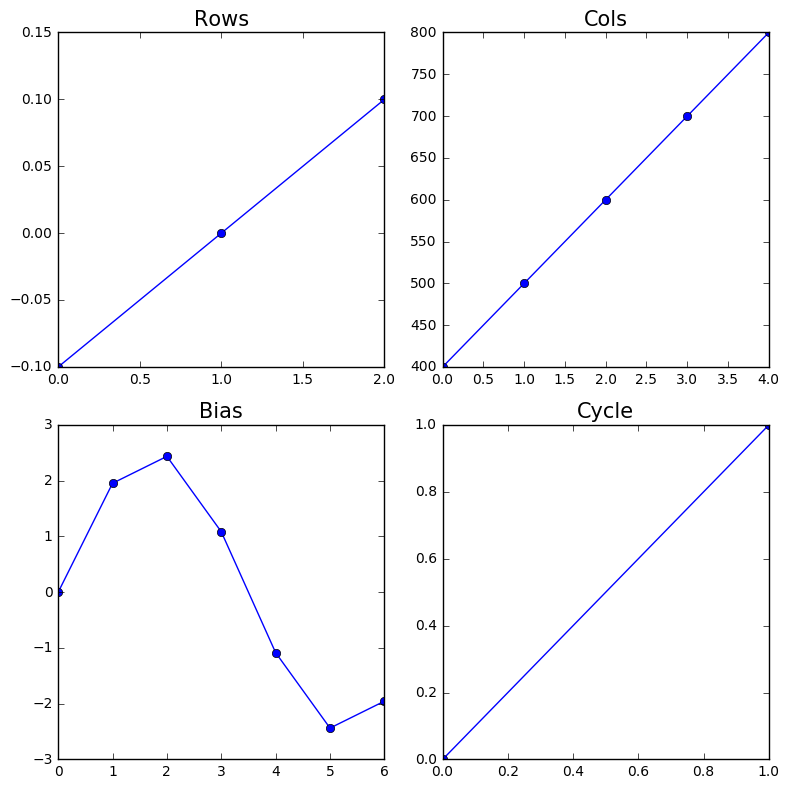

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 7))
for axis, vals, dim_name in zip(axes.flat, [rows_vals, cols_vals, bias_vals, cycle_vals], 
                                ['Rows', 'Cols', 'Bias', 'Cycle']):
    axis.set_title(dim_name, fontsize=15)
    axis.plot(vals, 'o-')
fig.tight_layout()

In pycroscopy, position and spectrosocpic dimensions are defined using some basic information that will be incorporated in Dimension objects that contain three vial pieces of information:
* Name of the dimension
* units for the dimension
* values:
    * These can be the actual values over which the dimension was varied
    * or number of steps in case of linearly varying dimensions such as 'Cycle' below 
    
Note that the Dimension objects in the lists for Positions and Spectroscopic must be arranged from fastest varying to slowest varying to mimic how the data is actually arranged. For example, in this example, there are multiple bias points per cycle and multiple columns (X) per row (Y) of data. Thus, the bias changes faster than the cycle and the columns (X) change faster than the rows (Y). Therefore, the  Cols must come before the Rows and Bias must precede the Cycle dimension:

In [17]:
pos_dims = [px.write_utils.Dimension('Cols', 'nm', cols_vals), 
            px.write_utils.Dimension('Rows', 'um', rows_vals)]
spec_dims = [px.write_utils.Dimension('Bias', 'V', bias_vals), 
            px.write_utils.Dimension('Cycle', '', num_cycles)]

write_main_dataset()
-------------------

Often, data is is recorded (from instruments) or generated (as a result of some analysis) in chunks (for example - one position at a time). Therefore, it makes sense to first create an empty dataset and then fill in the data as it is generated / recorded. 

We will only create an empty dataset first by specifying how large the dataset should be and of what data type (specified using the dtype keyword argument). Later, we will go over examples where the whole data is available when creating the HDF5 dataset. The *write_main_dataset* is one of the most important and popularly used functions in hdf_utils since it handles:
* thorough validation of all inputs
* the creation of the central dataset
* the creation of the ancillary datasets (if necessary)
* linking the ancillary datasets such that the central dataset becomes a *Main* dataset
* writing attributes

We could use the write_simple_attrs() function to write attributes to Raw_Data at a later stage but we can always pass these attributes to be written at the time of dataset creation if they are already known

In [18]:
h5_raw = px.hdf_utils.write_main_dataset(h5_meas_group, (num_rows * num_cols, bias_pts * num_cycles), 
                                         'Raw_Data', 'Current', 'nA', pos_dims, spec_dims, dtype=np.float32,
                                         main_dset_attrs={'IO_rate': 4E+6, 'Amplifier_Gain': 9})
print(h5_raw)

<HDF5 dataset "Raw_Data": shape (15, 14), type "<f4">
located at: 
/Measurement_000/Raw_Data 
Data contains: 
Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
Rows - size: 3 
Cols - size: 5 
Spectroscopic Dimensions: 
Bias - size: 7 
Cycle - size: 2


Let us take a look at the contents of the file again using the print_tree() functon. What we see is that five new datasets have been created: 
* **Raw_Data** was created to contain the 4D measurement we are interested in storing. 
* **Spectrocopic_Indices** and **Spectrocopic_Values** contain the information about the spectroscopic dimensions
* **Position_Indices** and **Position_Values** contain the position related information

The underline below **Measurement_000** indicates that this is a HDF5 Group

In [19]:
px.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


As mentioned in our document about the data_format, the four supporting datasets (Position and Spectroscopic Indices and Values) help provide meaning to each element in Raw_Data such as dimensionality, etc. 

Only the Raw_Data dataset is a Pycroscopy Main dataset while all other datasets are just supporting datasets. We can verify whether a dataset is a Main dataset or not using the check_if_main() function: 

In [20]:
for dset in [h5_raw, h5_raw.h5_spec_inds, h5_raw.h5_pos_vals]:
    print('Is {} is a Main dataset?: {}'.format(dset.name, px.hdf_utils.check_if_main(dset)))

Is /Measurement_000/Raw_Data is a Main dataset?: True
Is /Measurement_000/Spectroscopic_Indices is a Main dataset?: False
Is /Measurement_000/Position_Values is a Main dataset?: False


Populating the Dataset:
---------------------

Note that h5_main still does not contain the values we are interested in filling it in with:

In [22]:
h5_raw[5]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

Let us simulate a situation where we are recording the data a pixel at a time and writing it to the h5_main dataset:

In [23]:
source_main_data = np.random.rand(num_rows * num_cols, bias_pts * num_cycles)

for pixel_ind, pixel_data in enumerate(source_main_data):
    h5_raw[pixel_ind] = pixel_data

# Make sure to flush the file (write anything in the buffer into the file)
h5_file.flush()

Note that we were only simulating a (realistic) situation where all the data was not present at once to write into Raw_Data dataset. Let us check the contents at a particular position in the dataset now:

In [24]:
h5_raw[5]

array([ 1000.,  1001.,  1002.,  1003.,  1004.,  1005.,  1006.,  1010.,
        1011.,  1012.,  1013.,  1014.,  1015.,  1016.], dtype=float32)

Exploring attributes in Main datasets:
------------------------------------

Some of the main requirements for promoting a regular dataset to a Main dataset are some mandatory attributes attached to the dataset:
* quantity - What the stored data contains - for example: current, temperature, voltage, strain etc.
* units - the units for the quantity, such as Amperes, meters, etc.
* links to each of the four ancillary datasets 

Again, we can use the get_attributes() function to see if and how these attributes are stored:

In [25]:
px.hdf_utils.get_attributes(h5_raw)

{'Amplifier_Gain': 9,
 'IO_rate': 4000000.0,
 'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'XPSOne.hsd1.tn.comcast.net.',
 'platform': 'Windows-10-10.0.16299-SP0',
 'pycroscopy_version': '0.59.7',
 'quantity': 'Current',
 'timestamp': '2018_04_21-14_08_53',
 'units': 'nA'}

While it is straightforward to read simple attributes like quantity or units, the values for Position_Values or Spectroscopic_Indices attributes seem cryptic. These are just references or links to other datasets. 

In [26]:
px.hdf_utils.get_attr(h5_raw, 'Position_Indices')

<HDF5 object reference>

Object references as attributes
=================

Reading linkages
-----------------

We can get access to linked datasets using get_auxillary_datasets():

In [27]:
px.hdf_utils.get_auxillary_datasets(h5_raw, 'Position_Indices')

[<HDF5 dataset "Position_Indices": shape (15, 2), type "<u4">]

Note that this function returns all datasets named 'Position_Indices' under a group or Dataset in a list. In this case, we know that the list should only have one value. 

Given that h5_raw is a Main dataset, and Position_Indices is one of the four essential components of a Main dataset, the Pycrodataset object makes it far easier to access the ancillary datasets without neededing to call a function as above. PycroDataset will be discussed in greater detail in a separate notebook.

Creating linkages
----------------

What do we do if we need to store some other supporting information regarding some measurement? If such supporting datasets do not need to be Pycroscopy Main datasets, we could simply use the basic functionality of h5py to create the dataset

In [28]:
h5_other = h5_meas_group.create_dataset('Other', np.random.rand(5))

Pycroscopy files tend to have a fair number of datasets in them and the most important ones are Main datasets and users tend to "walk" or "hop" through the file by stepping only on the Main datasets. Thus, we often want to link supporting datasets to the relevant Main datasets. This way, such supporting datasets can be accessed via an attribute of the Main dataset instead of having to manually specify the path of the supporting dataset.

link_h5_objects_as_attrs()
--------------------------

link_h5_objects_as_attrs() makes it easy to link a dataset or group to any other dataset or group. In this example we will link the 'Other' dataset to the Main dataset:

In [29]:
px.hdf_utils.link_h5_objects_as_attrs(h5_raw, h5_other)
px.hdf_utils.get_attributes(h5_raw)

{'Amplifier_Gain': 9,
 'IO_rate': 4000000.0,
 'Other': <HDF5 object reference>,
 'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'XPSOne.hsd1.tn.comcast.net.',
 'platform': 'Windows-10-10.0.16299-SP0',
 'pycroscopy_version': '0.59.7',
 'quantity': 'Current',
 'timestamp': '2018_04_21-14_08_53',
 'units': 'nA'}

In the same way, we can even link a group to the Other dataset:

In [30]:
px.hdf_utils.link_h5_objects_as_attrs(h5_other, h5_some_group)
px.hdf_utils.get_attributes(h5_other)

{'Some_Group': <HDF5 object reference>}

What we see above is that 'Other' is now an attribute of the 'Raw_Data' dataset. 

One common scenario in scientific workflows is the storage of multiple Main Datasets within the same group. The first Main dataset can be stored along with its four ancillary datasets without any problems. However, if the second Main dataset also requires the storage of Position and Spectroscopic datasets, these datasets would need to be named differently to avoid conflicts with existing datasets (associated with the first Main dataset). Moreover, these ancillary datasets would need to be linked to the second Main dataset with the standard 'Position_..' and 'Spectroscopic_..' names for the attributes. 

link_h5_obj_as_alias()
----------------------
The link_h5_obj_as_alias() is handy in this scenario since it allows a dataset or group to be linked with a name different from its actual name. For example, we can link the 'Raw_Data' dataset to the 'Other' dataset with an alias:

In [31]:
px.hdf_utils.link_h5_obj_as_alias(h5_other, h5_raw, 'Mysterious_Dataset')

px.hdf_utils.get_attributes(h5_other)

{'Mysterious_Dataset': <HDF5 object reference>,
 'Some_Group': <HDF5 object reference>}

The datased named 'Other' has a new attribute named 'Mysterious_Dataset'. Let us show that this dataset is none other than Raw_Data: 

In [32]:
h5_myst_dset = px.hdf_utils.get_auxillary_datasets(h5_other, 'Mysterious_Dataset')[0]
print(h5_myst_dset == h5_raw)

True


Processing on Datasets
==============
Let us assume that we are normalizing the data in some way and we need to write the results back to the file. As far as the data shapes and dimensionality are concerned, let us assume that the data still remains a 4D dataset. 

create_results_group()
---------------------
Let us first start off with creation of a HDF5 Group that will contain the results. If you recall, groups that contain the results of some processing / analysis on a source dataset are named as 'Source_Dataset_name-Process_Name_00x' where x is the index of the group. The create_results_group() function makes it very easy to create a group with such nomenclature and indexing:

In [33]:
h5_results_group_1 = px.hdf_utils.create_results_group(h5_raw, 'Normalization')
print(h5_results_group_1)

<HDF5 group "/Measurement_000/Raw_Data-Normalization_000" (0 members)>


Let us make up some data which is the result of some Normalization on the Raw_Data:

In [34]:
norm_data = np.random.rand(num_rows * num_cols, bias_pts * num_cycles)

Writing a main dataset
---------------------

In this scenario we will demonstrate how one might write a Main dataset when having the complete processed (in this case some normalization) data is available before even creating the dataset.

One more important point to remember here is that the normalized data is of the same shape and dimensionality as 'Raw_Data'. Therefore, we need not unnecessarily create ancillary datasets - we can simply refer to the ones that support 'Raw_Data'. During the creation of 'Raw_Data', we passed the pos_dims and spec_dims parameters for the creation of new Ancillary datasets. In this case, we will show how we can ask the write_main_dataset() to reuse existing ancillary datasets:

In [35]:
h5_norm = px.hdf_utils.write_main_dataset(h5_results_group_1, norm_data, 'Normalized_Data', 'Current', 'nA', 
                                          None, None, 
                                          h5_pos_inds=h5_raw.h5_pos_inds, h5_pos_vals=h5_raw.h5_pos_vals, 
                                          h5_spec_inds=h5_raw.h5_spec_inds, h5_spec_vals=h5_raw.h5_spec_vals)
print(h5_norm)

<HDF5 dataset "Normalized_Data": shape (15, 14), type "<f8">
located at: 
/Measurement_000/Raw_Data-Normalization_000/Normalized_Data 
Data contains: 
Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
Rows - size: 3 
Cols - size: 5 
Spectroscopic Dimensions: 
Bias - size: 7 
Cycle - size: 2


When we look at the contents of hte file again, what we see below is that the newly created group 'Raw_Data-Normalization_000' only contains the 'Normalized_Data' dataset and none of the supporting ancillary datasets since it is sharing the same ones created for 'Raw_Data' 

In [36]:
px.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Other
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Raw_Data-Normalization_000
    --------------------------
    ├ Normalized_Data
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


Shared ancillary datasets
---------------------------------
Let us verify that 'Raw_Data' and 'Normalized_Data' share the same ancillary datasets:

In [37]:
for anc_name in ['Position_Indices', 'Position_Values', 'Spectroscopic_Indices', 'Spectroscopic_Values']:
    # get the handle to the ancillary dataset linked to 'Raw_Data'
    raw_anc = px.hdf_utils.get_auxillary_datasets(h5_raw, anc_name)[0]
    # get the handle to the ancillary dataset linked to 'Normalized_Data'
    norm_anc = px.hdf_utils.get_auxillary_datasets(h5_norm, anc_name)[0]
    # Show that these are indeed the same dataset
    print('Sharing {}: {}'.format(anc_name, raw_anc == norm_anc)) 

Sharing Position_Indices: True
Sharing Position_Values: True
Sharing Spectroscopic_Indices: True
Sharing Spectroscopic_Values: True


Unlike last time with 'Raw_Data', we wrote the data to the file when creating 'Normalized_Data', so let us check to make sure that we did in fact write data to disk:

In [38]:
print(h5_norm[5])

[ 0.04402251  0.9314648   0.62175054  0.2936163   0.25153665  0.95741689
  0.60418902  0.6436971   0.02944552  0.47874527  0.85188949  0.10467687
  0.96178644  0.06229508]


Duplicating Datasets
=============

create_empty_dataset()
---------------------
Let us say that we are interested in writing out another dataset that is again of the same shape and dimensionality as 'Raw_Data' or 'Normalized_Data'. There is another way to create an empty dataset identical to an existing dataset, and then fill it in. This approach is an alternative to the approach used for 'Normalized_Data':

In [39]:
h5_offsets = px.hdf_utils.create_empty_dataset(h5_norm, np.float32, 'Offsets')
print(h5_offsets)

<HDF5 dataset "Offsets": shape (15, 14), type "<f4">
located at: 
/Measurement_000/Raw_Data-Normalization_000/Offsets 
Data contains: 
Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
Rows - size: 3 
Cols - size: 5 
Spectroscopic Dimensions: 
Bias - size: 7 
Cycle - size: 2


In this very specific scenario, we duplicated practically all aspects of 'Normalized_Data', including its links to the ancillary datasets. Thus, this h5_offsets automatically also becomes a Main dataset. 

However, it is empty and needs to be populated

In [40]:
print(h5_offsets[6])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Since this is an example, we will populate the dataset using same data prepare for norm_data

In [41]:
h5_offsets[()] = norm_data
print(h5_offsets[6])

[ 0.91192567  0.23039342  0.29715368  0.90831453  0.89278263  0.65489841
  0.0317811   0.34148139  0.46433461  0.70488864  0.28679696  0.69362658
  0.01249913  0.98213148]


Creating Ancillary datasets
===============

Often, certain processing of data involves the removal of one or more dimensions (typically Spectroscopic). This necessitates careful generation of indices and values datasets. In our example, we will remove the spectroscopic dimension - 'Bias' and leave the position dimensions as is. While we could simply regenerate the spectroscopic indices from scratch knowing that the only remaining spectroscopic dimension is 'Cycle', this is not feasible when writing robust code where we have minimal control or knowledge about the other dimensions. This is especially true when there are 3 or more spectroscopic dimensions and we do not know relationships between the spectroscopic dimensions or the rates of change in these spectroscopic dimensions. Fortunately, hdf_utils.write_reduced_spec_dsets() substantially simplifies this problem as shown below.

First, we still need to create the results HDF5 group to hold the results:

In [42]:
h5_analysis_group = px.hdf_utils.create_results_group(h5_norm, 'Fitting')

Let us take a look at the contents of the HDF5 file again. Clearly, we do not have any new datasets underneath 'Normalized_Data-Fitting_000'

In [43]:
px.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Other
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Raw_Data-Normalization_000
    --------------------------
    ├ Normalized_Data
    ├ Normalized_Data-Fitting_000
      ---------------------------
    ├ Offsets
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


write_reduced_spec_dsets()
-------------------------
Now we make the new spectroscopic indices and values datasets while removing the 'Bias' dimension

In [44]:
h5_spec_inds, h5_spec_vals = px.hdf_utils.write_reduced_spec_dsets(h5_analysis_group, 
                                                                   h5_norm.h5_spec_inds, 
                                                                   h5_norm.h5_spec_vals, 
                                                                   'Bias')
print(h5_spec_inds)

<HDF5 dataset "Spectroscopic_Indices": shape (1, 2), type "<u4">


Let us take a look at the contents only inside h5_analysis_group now. Clearly, we have created two new spectroscopic ancillary datasets.

In [45]:
px.hdf_utils.print_tree(h5_analysis_group)

/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000
├ Spectroscopic_Indices
├ Spectroscopic_Values


write_ind_val_dsets()
---------------------

Similar to write_reduced_spec_dsets(), hdf_utils also has another function called write_ind_val_dsets() that is handy when one needs to create the ancillary datasets before write_main_dataset() is called. For example, consider a data processing algorithm that may or may not change the position dimensions. You may need to structure your code this way:

```python
if position dimensions are unchanged:
    # get links to datasets from the source dataset
    h5_pos_inds, h5_pos_vals = h5_source.h5_pos_inds, h5_source.h5_pos_vals
else:
    # Need to create fresh HDF5 datasets
    h5_pos_inds, h5_pos_vals = write_ind_val_dsets()

# At this point, it does not matter how we got h5_pos_inds, h5_pos_vals. We can simply link them when we create the main dataset
h5_new_main = write_main_dataset(...., h5_pos_inds=h5_pos_inds, h5_pos_vals=h5_pos_vals)

```

Even though we already decided that we would not be changing the position dimensions for this particular example, we will demonstrate the usage of write_ind_val_dsets() to make position indices and values HDF5 datasets (that are identical to the ones already linked to h5_norm)

In [46]:
h5_pos_inds, h5_pos_vals = px.hdf_utils.write_ind_val_dsets(h5_analysis_group, pos_dims, is_spectral=False)

Looking at the contents of Normalized_Data-Fitting_000 now reveals that we have added the Position datasets as well. However, we still do not have the main dataset.

In [47]:
px.hdf_utils.print_tree(h5_analysis_group)

/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000
├ Position_Indices
├ Position_Values
├ Spectroscopic_Indices
├ Spectroscopic_Values


Finally, we can create and write a Main dataset with some results using the trusty write_main_dataset function. Since we have created both the Spectroscopic and Position HDF5 dataset pairs, we simply ask write_main_dataset() to re-use + link them.

In [48]:
reduced_main = np.random.rand(num_rows * num_cols, num_cycles)
h5_cap_1 = px.hdf_utils.write_main_dataset(h5_analysis_group, reduced_main, 'Capacitance', 'Capacitance', 'pF', 
                                           None, None, h5_spec_inds=h5_spec_inds, h5_spec_vals=h5_spec_vals,
                                           h5_pos_inds=h5_pos_inds, h5_pos_vals=h5_pos_vals)
print(h5_cap_1)

<HDF5 dataset "Capacitance": shape (15, 2), type "<f8">
located at: 
/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000/Capacitance 
Data contains: 
Capacitance (pF) 
Data dimensions and original shape: 
Position Dimensions: 
Rows - size: 3 
Cols - size: 5 
Spectroscopic Dimensions: 
Cycle - size: 2


Multiple Main Datasets
=============

Let's say that we need to create a new Main dataset within the same folder as 'Capacitance' called 'Mean_Capacitance'. 'Mean_Capacitance' would just be a spatial map with average capacitance so it would not even have the 'Cycle' Spectroscopic dimension. This means that we can reuse the newly created Position ancillary datasets but we would need to create new Spectroscopic_Indices and Spectroscopic_Values datasets in the same folder to express the 0 dimensions in the spectroscopic axis for this new dataset. However, we already have datasets of this name that we created above using the write_reduced_spec_dsets() function. Recall, that the criterion for a Main dataset is that it should have attributes of name 'Spectroscopic_Indices' and 'Spectroscopic_Values'. It does not matter what the actual name of the linked datasets are. Coming back to the current example, we could simply ask write_main_dataset() to name the spectroscopic datasets with a different prefix - 'Empty_Spec' instead of 'Spectroscopic' via the 'aux_spec_prefix' keyword argument (last line). This allows the creation of the new Main Dataset without any name clashes with existing datasets:

In [49]:
h5_cap_2 = px.hdf_utils.write_main_dataset(h5_analysis_group, np.random.rand(num_rows * num_cols, 1), 
                                           'Mean_Capacitance', 'Capacitance', 'pF', 
                                           None, px.write_utils.Dimension('Capacitance', 'pF', 1), 
                                           h5_pos_inds=h5_pos_inds, h5_pos_vals=h5_pos_vals,
                                           aux_spec_prefix='Empty_Spec')
print(h5_cap_2)

<HDF5 dataset "Mean_Capacitance": shape (15, 1), type "<f8">
located at: 
/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000/Mean_Capacitance 
Data contains: 
Capacitance (pF) 
Data dimensions and original shape: 
Position Dimensions: 
Rows - size: 3 
Cols - size: 5 
Spectroscopic Dimensions: 
Capacitance - size: 1


Clearly, 'Mean_Capacitance' and 'Capacitance' are two Main datasets that coexist in the same HDF5 group along with their necessary ancillary datasets. 

Now, let us look at the contents of the group: Normalized_Data-Fitting_000 to verify this:

In [50]:
px.hdf_utils.print_tree(h5_analysis_group)

/Measurement_000/Raw_Data-Normalization_000/Normalized_Data-Fitting_000
├ Capacitance
├ Empty_Spec_Indices
├ Empty_Spec_Values
├ Mean_Capacitance
├ Position_Indices
├ Position_Values
├ Spectroscopic_Indices
├ Spectroscopic_Values


* create analysis results
    * create main dataset with data but reuse only one set of ancillary datasets from source
        * write simple attributes
* create a new results group
    * copy attributes from other results

File status
===========

is_editable_h5()
----------------
When writing a class or a function that modifies or adds data to an existing HDF5 file, it is a good idea to check to make sure that it is indeed possible to write the new data to the file. is_editable_h5() is a handy function for this very purpose:

In [51]:
print('Is the file editable?: {}'.format(px.hdf_utils.is_editable_h5(h5_file)))

Is the file editable?: True


If we close the file and try again we should expect runtime and Value errors. You can try this by yourself if you like.

In [52]:
h5_file.close()
# print('Is the file editable?: {}'.format(px.hdf_utils.is_editable_h5(h5_file)))

Let us try again by opening this file in read-only mode:

In [53]:
# Open the file again in r mode:
h5_file = h5py.File('test.h5', mode='r')
print('Is the file editable?: {}'.format(px.hdf_utils.is_editable_h5(h5_file)))

Is the file editable?: False


In [54]:
h5_file.close()